In [ ]:
# Imports

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import os

from torchvision import datasets, transforms



In [ ]:
# Configuration and hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# VAE hyperparameters
vae_latent_dim = 64
vae_hidden_dim = 400
vae_epochs = 5
vae_batch_size = 128
vae_lr = 1e-3

# Diffusion hyperparameters
diffusion_T = 250         # number of diffusion steps
diffusion_epochs = 10
diffusion_batch_size = 128
diffusion_lr = 2e-4


Using device: cuda


In [ ]:
import gdown
import zipfile

os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile(output, "r") as zipobj:
        zipobj.extractall("celeba_gan")

In [ ]:
# MNIST dataset


transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])


from torchvision.datasets import ImageFolder
dataset = ImageFolder(root="celeba_gan", transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_loader_vae = DataLoader(train_dataset, batch_size=vae_batch_size, shuffle=True)
test_loader_vae = DataLoader(test_dataset, batch_size=vae_batch_size, shuffle=False)


print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 182339 Test size: 20260


## 1. VAE: CELEBA → Latent → CELEBA



In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 64x32x32
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1), # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 4, 2, 1), # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, 4, 2, 1), # 512x4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

        # The encoder output is shape: (512, 4, 4) → 512*4*4 = 8192
        self.flat_dim = 512 * 4 * 4

        # Latent parameters
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, self.flat_dim)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 3x64x64
            nn.Tanh()  # output in [-1,1]
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 512, 4, 4)
        x_hat = self.decoder_conv(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction loss (pixel MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    loss = (recon_loss + kl) / x.size(0)
    return loss, recon_loss / x.size(0), kl / x.size(0)


In [ ]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=vae_lr)

print(vae)


VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=8192, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=8192, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_si

In [20]:
# Train VAE

vae.train()
for epoch in range(1, vae_epochs + 1):
    total_loss = 0.0
    total_bce = 0.0
    total_kl = 0.0
    n_samples = 0

    for x, _ in train_loader_vae:
        x = x.to(device)

        vae_optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss, bce, kl = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        vae_optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item()
        total_bce += bce.item()
        total_kl += kl.item()
        n_samples += batch_size

    avg_loss = total_loss / n_samples
    avg_bce = total_bce / n_samples
    avg_kl = total_kl / n_samples

    print(f"[VAE] Epoch {epoch:02d} | Loss: {avg_loss:.4f} (BCE {avg_bce:.4f}, KL {avg_kl:.4f})")


[VAE] Epoch 01 | Loss: 2735965.5637 (BCE 7.7950, KL 2735957.7921)
[VAE] Epoch 02 | Loss: 6.4666 (BCE 5.5847, KL 0.8819)
[VAE] Epoch 03 | Loss: 6.0249 (BCE 5.1190, KL 0.9059)
[VAE] Epoch 04 | Loss: 5.7681 (BCE 4.8511, KL 0.9171)
[VAE] Epoch 05 | Loss: 5.5947 (BCE 4.6696, KL 0.9252)


## Reconstruction

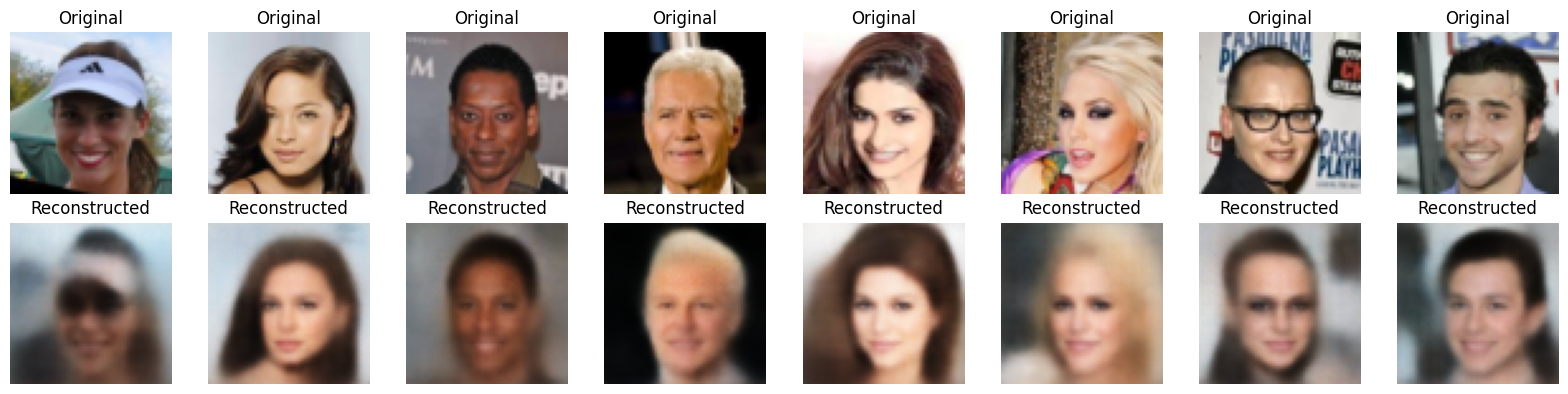

In [21]:
vae.eval()
x_batch, _ = next(iter(test_loader_vae))   # use your CelebA dataloader
x_batch = x_batch.to(device)

with torch.no_grad():
    x_hat, mu, logvar = vae(x_batch)

x_batch = x_batch.cpu()
x_hat = x_hat.cpu()

# Convert from [-1,1] → [0,1] for rendering
x_batch = (x_batch + 1) / 2
x_hat = (x_hat + 1) / 2

# Plot
n = 8
plt.figure(figsize=(2 * n, 4))

for i in range(n):

    plt.subplot(2, n, i + 1)
    plt.imshow(x_batch[i].permute(1, 2, 0))  # (3,64,64) → (64,64,3)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_hat[i].permute(1, 2, 0))
    plt.axis("off")
    plt.title("Reconstructed")

plt.tight_layout()
plt.show()


## Generation

In [22]:
vae.eval()

@torch.no_grad()
def encode_to_latent(x):
    x = x.to(device)
    mu, logvar = vae.encode(x)
    return mu



In [23]:
# Diffusion utilities

T = diffusion_T

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)

def q_sample(z0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1)
    sqrt_one_minus = torch.sqrt(1.0 - alphas_cumprod[t]).view(-1, 1)
    return sqrt_alpha_bar * z0 + sqrt_one_minus * noise

In [24]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, dim):
        super().__init__()
        self.emb = nn.Embedding(T, dim)

    def forward(self, t):
        return self.emb(t)


class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim, time_dim=32, hidden_dim=128, T=100):
        super().__init__()
        self.time_emb = TimeEmbedding(T, time_dim)
        self.fc1 = nn.Linear(latent_dim + time_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_t, t):
        t_emb = self.time_emb(t)
        x = torch.cat([z_t, t_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        eps_pred = self.fc3(x)
        return eps_pred


In [25]:
diffusion_model = LatentDenoiser(
    latent_dim=64,
    time_dim=32,
    hidden_dim=128,
    T=T
).to(device)

diffusion_optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=diffusion_lr)

print(diffusion_model)


LatentDenoiser(
  (time_emb): TimeEmbedding(
    (emb): Embedding(250, 32)
  )
  (fc1): Linear(in_features=96, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
)


In [26]:
train_loader_diffusion = DataLoader(train_dataset, batch_size=diffusion_batch_size, shuffle=True)


In [27]:
# Train diffusion model

diffusion_model.train()

for epoch in range(1, diffusion_epochs + 1):
    total_loss = 0.0
    n_batches = 0

    for x, _ in train_loader_diffusion:
        x = x.to(device)
        batch_size = x.size(0)

    # Encode image to latent
        with torch.no_grad():
          mu, logvar = vae.encode(x)
          z0 = mu    # (batch, latent_dim)

        t = torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)

        noise = torch.randn_like(z0)
        z_t = q_sample(z0, t, noise=noise)

        eps_pred = diffusion_model(z_t, t)

        loss = F.mse_loss(eps_pred, noise)

        diffusion_optimizer.zero_grad()
        loss.backward()
        diffusion_optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / n_batches
    print(f"[Diffusion] Epoch {epoch:02d} | MSE loss: {avg_loss:.6f}")


[Diffusion] Epoch 01 | MSE loss: 0.782574
[Diffusion] Epoch 02 | MSE loss: 0.635109
[Diffusion] Epoch 03 | MSE loss: 0.599572
[Diffusion] Epoch 04 | MSE loss: 0.589856
[Diffusion] Epoch 05 | MSE loss: 0.587153
[Diffusion] Epoch 06 | MSE loss: 0.583314
[Diffusion] Epoch 07 | MSE loss: 0.581733
[Diffusion] Epoch 08 | MSE loss: 0.577429
[Diffusion] Epoch 09 | MSE loss: 0.576123
[Diffusion] Epoch 10 | MSE loss: 0.574572


In [28]:
# Sampling from diffusion + decode with VAE

@torch.no_grad()
def p_sample_step(z_t, t):
    b = z_t.size(0)
    t_tensor = torch.full((b,), t, device=device, dtype=torch.long)
    eps_pred = diffusion_model(z_t, t_tensor)

    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alphas_cumprod[t]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)

    z0_est = (z_t - sqrt_one_minus_alpha_bar_t * eps_pred) / torch.sqrt(alpha_bar_t)

    if t > 0:
        alpha_bar_prev = alphas_cumprod[t - 1]
        coef1 = torch.sqrt(alpha_bar_prev) * beta_t / (1.0 - alpha_bar_t)
        coef2 = torch.sqrt(alpha_t) * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        mean = coef1 * z0_est + coef2 * z_t
        var = beta_t * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        noise = torch.randn_like(z_t)
        z_prev = mean + torch.sqrt(var) * noise
    else:
        z_prev = z0_est
    return z_prev


@torch.no_grad()
def sample_latent_and_decode(n_samples=16):
    diffusion_model.eval()
    vae.eval()

    z_t = torch.randn(n_samples, vae_latent_dim, device=device)

    for t in reversed(range(T)):
        z_t = p_sample_step(z_t, t)

    x_hat_flat = vae.decode(z_t)
    return x_hat.cpu()


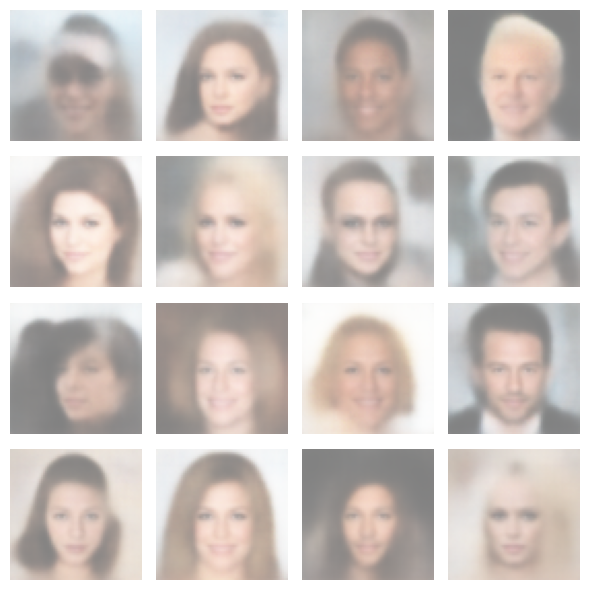

In [31]:
samples = sample_latent_and_decode(n_samples=16)

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)

    img = samples[i]
    img = (img + 1) / 2
    img = img.clamp(0, 1)

    img = img.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [30]:
torch.save({
    "vae_state": vae.state_dict(),
    "diffusion_state": diffusion_model.state_dict(),
    "optimizer_state": diffusion_optimizer.state_dict(),
}, "checkpoint_celeba.pth")


FileNotFoundError: Cannot find file: celeba_checkpoint.pth